1. All the necessary imports

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import skimage
import glob 
import os 
import random
import numpy as np
import pandas as pd
from PIL import ImageFile
from sklearn.model_selection import train_test_split

#what is the role of truncated images?
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Sequential, models
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications import efficientnet, vgg16
from keras.metrics import Recall
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import auth
auth.authenticate_user()


In [4]:
from google.cloud import storage

2. Loading raw data

In [5]:
def download_blob(bucket_name, parent_blob: str):
    """Downloads a blob from the bucket."""
    #create client
    storage_client = storage.Client()

    #fetch blob
    blobs = storage_client.list_blobs(bucket_name)

    #make host directory if it doesn't exist
    if not os.path.isdir(parent_blob):
        os.mkdir(parent_blob)

    for blob in blobs:
        #where I want it stored!
        blob.download_to_filename(blob.name)
    return True

In [6]:
import zipfile

def extract_to(parent_blob):
    ##Unzips all files in our parent blob we just downloaded from GCS
    for zipped_file in os.listdir(parent_blob):
        print(f"Unzipping {zipped_file}...")
        with zipfile.ZipFile(os.path.join(parent_blob, zipped_file),
                             'r') as zip_ref:
            #we do not define an extraction directory since the zipped files already contain
            #the directories, since there was a large folder containing
            #all subsequent folders with files belonging to each category
            zip_ref.extractall()
        print("Success!")

In [7]:
download_blob("mateo_trial","zipped_waves_expanded")

extract_to("zipped_waves_expanded")


Unzipping Good.zip...
Success!
Unzipping Chaotic.zip...
Success!
Unzipping Flat.zip...
Success!


3. Preprocessing function

In [8]:
def preprocess_image_improved(image):
    if image.shape == (570, 1015):
        cropped = image[250:-100,100:]
    elif image.shape == (582, 1034):
        cropped = image[60:500,:]
    elif image.shape == (624, 1200):
        cropped = image[150:,:]
    elif image.shape == (624, 1110):
        cropped = image[350:-100,:]
    else:
        cropped = image[150:,:]
        
    img = cv.resize(cropped,(300,300),interpolation = cv.INTER_AREA)
    img = cv.medianBlur(img,5)
    ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
    th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
                cv.THRESH_BINARY,11,2)
#     th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
#                 cv.THRESH_BINARY,15,2)
    images =[th1,img,th2]
    
    return images

4. Compiling and initilalizing functions

In [9]:
def compile_model(model, learning_rate=1e-4):
    model.compile(loss = "categorical_crossentropy",
                            optimizer = Adam(learning_rate=learning_rate),
                            metrics = ["accuracy"])
    return model

In [10]:
def initialize_efficientnet():
    n_classes = 3
    model = models.Sequential()
    model.add(
        efficientnet.EfficientNetB7(weights = 'imagenet',
                                     include_top = False,
                                     classes = n_classes,
                                     input_shape = (300, 300, 3))
    )
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dropout(0.2))

    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation = "relu"))
    
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dropout(0.15))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(n_classes, activation = "softmax"))
    model.layers[0].trainable = False
    return model

In [11]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 16, 
                   verbose = 1, 
                   restore_best_weights = True)

BEFORE YOU PERFORM NEXT STEPS MOVE THE FOLDERS INTO "raw_data" FOLDER

6. The most important part: getting data randomly from folders in chunks and then training the model

In [14]:
all_files = []
idx = 0

for root , dirs , files in os.walk("/content/raw_data"):
      if dirs:
          parent = root
          folders = dirs
          print(folders)
      if files:
          for file in files:
            path = os.path.join("/content/raw_data" , folders[idx] , file)
            all_files.append(path)
          idx += 1
len(all_files)

['Good', 'Chaotic', 'Flat']


900

In [15]:
labels = dict(Chaotic=0,Flat=2,Good=1)


def get_chunk(all_files , chunk_size = 50):
  import random
  random.shuffle(all_files)
  idx = 1
  while True:
    chunk_files = all_files[chunk_size*(idx-1):chunk_size*idx]
    if len(chunk_files) == 0:
      break
    X = []
    y = []
    for file in chunk_files:
      try:
        original_image = cv.imread(file, 0)
        original_image
        original_image = preprocess_image_improved(original_image)
        if len(original_image) < 2:
            print(f"problemita in {file}")
        else:
            X.append(np.array(original_image).T)
            folder_name = file.split("/")[-2]
            label = labels.get(folder_name)
            y.append(label)
      except Exception:
        print("BAD FILE")
        continue
    X = np.array(X)
    y = np.array(y)
    yield X , y
    idx += 1
#data_gen = get_chunk(all_files)
#X.shape , y.shape

In [16]:
data_gen = get_chunk(all_files, chunk_size = 300)
test_model = initialize_efficientnet()
model = compile_model(test_model)

258076736/258076736 [==============================] - 8s 0us/step


In [17]:
X_final = []
y_final = []

for X , y in data_gen:
  print("FETCHING NEXT CHUNK")
  #print(X)
  print(X.shape , y.shape)
  y_cat = to_categorical(y)
  X_train, X_test, y_train, y_test = train_test_split(X, y_cat, train_size = 0.80)
  X_final.append(X_test)
  y_final.append(y_test)
  model.fit(X_train , y_train ,
                callbacks = [es] ,
                 validation_split = 0.2,
                 epochs = 64,
                 batch_size = 8)
  del X , y
  
X_final2 = np.array([item for sublist in X_final for item in sublist])
y_final2 = np.array([item for sublist in y_final for item in sublist])
model.evaluate(X_final2, y_final2)

FETCHING NEXT CHUNK
(300, 300, 300, 3) (300,)
Epoch 1/64
24/24 [==============================] - 215s 8s/step - loss: 1.5277 - accuracy: 0.3698 - val_loss: 1.0762 - val_accuracy: 0.5417
Epoch 2/64
24/24 [==============================] - 181s 8s/step - loss: 1.2684 - accuracy: 0.4844 - val_loss: 1.0585 - val_accuracy: 0.5000
Epoch 3/64
24/24 [==============================] - 178s 7s/step - loss: 1.0024 - accuracy: 0.5417 - val_loss: 1.0361 - val_accuracy: 0.5208
Epoch 4/64
24/24 [==============================] - 175s 7s/step - loss: 0.9317 - accuracy: 0.5990 - val_loss: 1.0153 - val_accuracy: 0.5000
Epoch 5/64
24/24 [==============================] - 184s 8s/step - loss: 0.8230 - accuracy: 0.6562 - val_loss: 1.0053 - val_accuracy: 0.5417
Epoch 6/64
24/24 [==============================] - 181s 8s/step - loss: 0.9250 - accuracy: 0.6042 - val_loss: 0.9758 - val_accuracy: 0.5417
Epoch 7/64
22/24 [==========================>...] - ETA: 11s - loss: 0.7425 - accuracy: 0.6989

KeyboardInterrupt: ignored

In [ ]:
y_final2.shape

(105, 3)

7. Saving model and cheking some pictures

In [ ]:
model.save("content/modelb7", save_format = "h5")

In [ ]:
test_image  = cv.imread("/content/test_3.png", 0)
test_image2  = cv.imread("/content/test_5.png", 0)

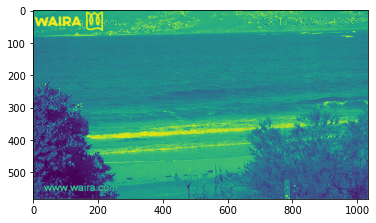

In [ ]:
plt.imshow(test_image) #80% good, 20% flat

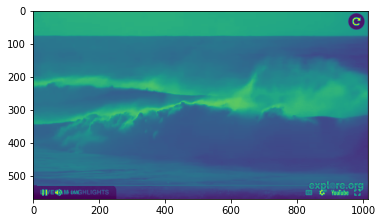

In [ ]:
plt.imshow(test_image2) #71% flat, 29% chaotic

In [ ]:
test_image = preprocess_image_improved(test_image)
test_image = np.array([(test_image)])
test_image = test_image.reshape(1,300,300,3)

In [ ]:
test_image2 = preprocess_image_improved(test_image2)
test_image2 = np.array([(test_image2)])
test_image2 = test_image2.reshape(1,300,300,3)

In [ ]:
model.predict(test_image)

1/1 [==============================] - 6s 6s/step


array([[0.00928645, 0.79327583, 0.19743769]], dtype=float32)

In [ ]:
model.predict(test_image2)

1/1 [==============================] - 0s 121ms/step


array([[0.27883843, 0.00534281, 0.7158187 ]], dtype=float32)